In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tqdm import tqdm


import math

In [2]:
class PreprocessingClass:
    def __init__(self, data, target_var, test_split_ratio = 0.2, stratify = False) -> None:

        self.data = data
        self.target_var = target_var
        self.test_split_ratio = test_split_ratio
        self.stratify = stratify

    def train_test_split_data(self, X, y):
        if self.stratify:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X ,y ,test_size= self.test_split_ratio, 
                                                                                    stratify= y, random_state= 42)
        else:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X ,y ,
                                                                                    test_size= self.test_split_ratio, random_state= 42)
    
    def train_normalize(self, X):
        mean = X.mean()
        std = X.std()
        X = (X - mean)/std
        return X, mean, std
    
    def test_normalize(self, X, mean, std):
        X = (X - mean)/std
        return X
    

    def fit(self):
        self.X_data = self.data.drop([self.target_var], axis = 1)
        self.y_data = self.data[self.target_var]

        self.train_test_split_data(self.X_data, self.y_data)
        
        self.X_train, mean, std = self.train_normalize(self.X_train)
        self.X_test = self.test_normalize(self.X_test, mean, std)

In [3]:
class LinearRegressionClass:
    def __init__(self, data, target, learning_rate = 0.00005, epsilon = 1e-8, 
                 max_iterations= 1000, method = "closed", loss_function_type = "L2", 
                 huber_delta = 1, reg_type = None, reg_lambda = 0, print_log = False, fit_intercept = True) -> None:
         
        """
        @data: pandas dataframe or np.array, Passed data,

        @does: Apply various Linear regression types,
        @return: model parameters,
        """
        
        self.fit_intercept = fit_intercept
        self.X = np.insert(data.to_numpy(),0,1,axis=1) if self.fit_intercept == True else data.to_numpy() #Made code flexibility for intercept
        self.y = target.to_numpy()
        
        # Loss function types
        self.loss_function_type = loss_function_type
        self.reg_type = reg_type
        
        # Regularization types
        self.reg_lambda = 0 if self.reg_type == None else reg_lambda
        self.learning_rate = learning_rate
        self.huber_delta = huber_delta
        self.epsilon = epsilon
        self.max_iterations = max_iterations
        
        # method takes closed, gd, sgd
        self.method = method
        self.weight = None
        
        self.print_log = print_log
    
    def rank(self): # rank calculation
        u, sigma, v = np.linalg.svd(self.X)
        return np.count_nonzero(sigma > 0)
    

    def linear_regression_closed_form(self): # closed form LR
        self.weight = np.matmul(np.linalg.inv(np.matmul(self.X.T , self.X) + self.reg_lambda * np.eye(self.X.shape[1])), np.matmul(self.X.T, self.y))

    def predict(self, X):
        return np.matmul(X, self.weight)
    
    
    def evaluation_metrics(self, X = None, y = None, mode = 'train'):
        
        if mode == "train":
            print("Training metrics")
            y_hat = self.predict(self.X)
            print("RMSE ", ((((y_hat - self.y) ** 2).sum())/len(self.y))** 0.5)
            print("SSE ", ((y_hat - self.y) ** 2).sum(), "\n")
        
        elif (mode == 'test') and (X is not None) and (y is not None):
            print("Test metrics")
            X = np.insert(X.to_numpy(),0,1,axis=1) if self.fit_intercept == True else X.to_numpy()
            y = y.to_numpy()
            y_hat = self.predict(X)
            print("RMSE ", ((((y_hat - y) ** 2).sum())/len(y))** 0.5)
            print("SSE ", ((y_hat - y) ** 2).sum(), "\n")

        
        


    def loss_functions(self, X, y): #Cost function for Ridge, Lasso and regularization.
        y_hat = self.predict(X)
        if self.loss_function_type == "L2":
            return (0.5 * (y_hat - y) ** 2).sum()
        
        if self.loss_function_type == "L1":
            return (abs(y_hat - y)).sum()
        
        if self.loss_function_type == "huber":
            huber_mse = 0.5*((y_hat - y) ** 2)
            huber_mae = self.huber_delta * (abs(y_hat - y) - 0.5 * self.huber_delta)
            return (np.where(np.abs(y - y_hat) <= self.huber_delta, huber_mse, huber_mae)).sum()


    def derivative_loss_functions(self, X, y):
        y_hat = self.predict(X)
        if self.loss_function_type == "L2":
            return np.matmul(X.T, (y_hat - y))
        
        if self.loss_function_type == "L1":
            return np.matmul(X.T, np.sign(y_hat - y))
        
        if self.loss_function_type == "huber":
            return np.where(np.abs(y_hat - y) <= self.huber_delta, np.matmul(X.T, (y_hat - y)) , self.huber_delta * np.matmul(X.T, np.sign(y_hat - y)))
        
    def reg_functions(self):
        if self.reg_type == "L2":
            return ((self.weight) ** 2).sum()
        
        if self.reg_type == "L1":
            return (abs(self.weight)).sum()
        else:
            return 0

    def derivative_reg_functions(self):

        if self.reg_type == "L2":
            return 2* self.weight
        
        if self.reg_type == "L1":
            return np.sign(self.weight)
        
        else:
            return 0
        
    def gradient_descent(self, X, y):
        costs = []
        iterations = []
        previous_cost = math.inf
        for iter in tqdm(range(1, self.max_iterations)):
            
            if self.method == "sgd":
                X_train, X_test, y_train, y_test = train_test_split(X ,y , train_size=0.1)
            
            elif self.method == "gd":
                X_train, y_train = X, y
            
            else:
                X_train, y_train = X, y
            
            step = self.learning_rate * (self.derivative_loss_functions(X_train, y_train) + self.reg_lambda * self.derivative_reg_functions())
            
            self.weight = self.weight - step
            
            
            ### RMSE cost
            
            current_cost = ((self.loss_functions(X_train, y_train) + self.reg_lambda * self.reg_functions())/X_train.shape[0]) ** 0.5
            #current_cost = (self.loss_functions(X_train, y_train) + self.reg_lambda * self.reg_functions())
            
            #print(current_cost)
            costs.append(current_cost)
            iterations.append(iter)
            
            if self.print_log:
                print("Step : " + str(iter) + ": ","\n")
                print("\t" + "change ",step, "\n")
                print("current_weights: ", self.weight)
                print("current_cost: ", current_cost)
                print("current_cost_change: ", abs(current_cost - previous_cost), "\n")
            
            if abs(current_cost - previous_cost) < self.epsilon:
                print("Done")
                break
            previous_cost = current_cost
        self.fig_plot(x_data = iterations, y_data = costs)
    

    def fit(self):

        if self.X.shape[0] <1000 and self.method == "closed" and (self.rank() == self.X.shape[1]) and (self.X.shape[0] > self.X.shape[1]):
            self.linear_regression_closed_form()
            print("Closed Form used")
            print(self.weight)
        else:
            #self.weight = np.random.randn(self.X.shape[1]) #We can consider random weights insted of zeros by uncommenting this line
            self.weight = np.zeros(self.X.shape[1])
            self.gradient_descent(self.X, self.y)
            print("Gradient descent used")
            print(self.weight)

    def fig_plot(self, x_data, y_data):
        
        plt.figure(figsize=(10,6))
        plt.title("Error Graph")
        plt.xlabel("Iterations")
        plt.ylabel("Cost")
        sns.lineplot(x= x_data, y= y_data)

## Analysis for housing dataset

In [4]:
df = pd.read_csv("Dataset\housing.csv")
df.head()

,0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
1,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


In [5]:
ppc = PreprocessingClass(data= df, target_var= "24", test_split_ratio = 0.3)
ppc.fit()

X_train, X_test, y_train, y_test = ppc.X_train, ppc.X_test, ppc.y_train, ppc.y_test
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((353, 13), (152, 13), (353,), (152,))

In [6]:
solver = LinearRegressionClass(data= X_train, target= y_train)
solver.fit()

Closed Form used
[23.09603399 -0.92471351  0.83903177  0.21691447  0.66419936 -2.03687948
  2.92064401  0.38972029 -2.92284537  2.58394111 -1.59491197 -2.36727378
  1.16320876 -4.11720415]


In [7]:
solver.evaluation_metrics(mode = 'train')
solver.evaluation_metrics(X = X_test, y = y_test, mode = 'test')

Training metrics
RMSE  4.859307179869883
SSE  8335.341792722253 

Test metrics
RMSE  4.345743214594052
SSE  2870.5935812529174 



- With L2 reg

In [8]:
solver = LinearRegressionClass(data= X_train, target= y_train, method = "closed", reg_type= "L2", reg_lambda= 1)
solver.fit()

Closed Form used
[23.03079096 -0.91353191  0.81923189  0.18844188  0.67032837 -1.99409987
  2.93095137  0.3759829  -2.8872603   2.48950836 -1.5170483  -2.3512156
  1.15932575 -4.09809842]


In [9]:
solver.evaluation_metrics(mode = 'train')
solver.evaluation_metrics(X = X_test, y = y_test, mode = 'test')

Training metrics
RMSE  4.859938812668311
SSE  8337.508857796594 

Test metrics
RMSE  4.338116337936641
SSE  2860.526510943868 



In [10]:
solver = LinearRegressionClass(data= X_train, target= y_train, method = "closed", reg_type= "L2", reg_lambda= 100)
solver.fit()

Closed Form used
[ 1.79975717e+01 -6.34825243e-01  3.49191726e-01 -3.56734176e-01
  8.04468904e-01 -6.84184417e-01  2.88449487e+00  1.27505643e-02
 -1.39584352e+00  4.74459896e-01 -3.88478907e-01 -1.70431010e+00
  9.38924842e-01 -3.05722717e+00]


In [11]:
solver.evaluation_metrics(mode = 'train')
solver.evaluation_metrics(X = X_test, y = y_test, mode = 'test')

Training metrics
RMSE  7.226948093807064
SSE  18436.758898955286 

Test metrics
RMSE  6.168785067877532
SSE  5784.194200477658 



- with large reg_lambda weights become small overfitting

  0%|          | 28/49999 [00:00<00:01, 27982.01it/s]

Done
Gradient descent used
[22.81651814 -0.65636906  0.35572517 -0.29517019  0.82429271 -0.79582001
  3.41821314  0.08348477 -1.92931905  0.79335762 -0.2680021  -2.00448175
  1.12769012 -3.75828645]


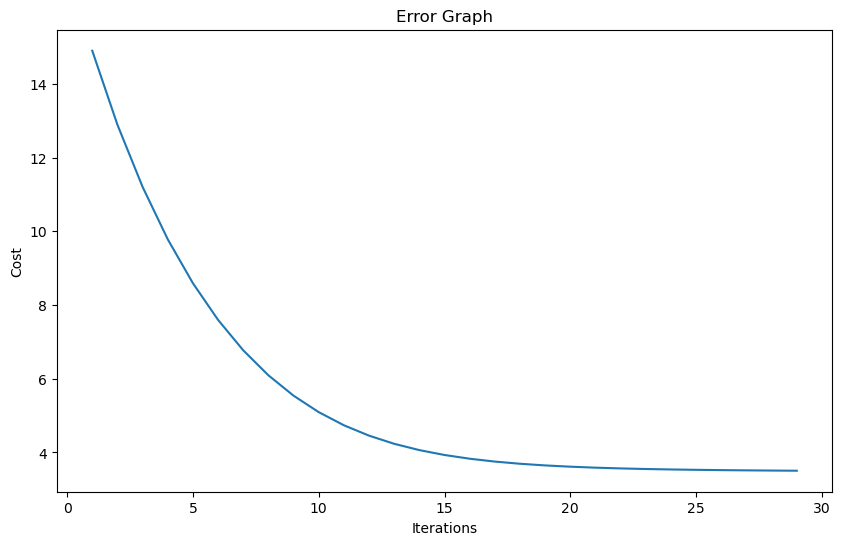

In [12]:
solver = LinearRegressionClass(data=X_train, target=y_train, learning_rate = 0.4e-3, epsilon = 0.5e-2, method = "gd", max_iterations = 50000)
solver.fit()

In [13]:
solver.evaluation_metrics(mode = 'train')
solver.evaluation_metrics(X = X_test, y = y_test, mode = 'test')

Training metrics
RMSE  4.957258160334033
SSE  8674.766189274022 

Test metrics
RMSE  4.438455359715097
SSE  2994.382668987918 



- From the above results we can observe that training and testing both values are increased when we used gradient descent.
- Based on the RMSE values, the normal equation method seems to provide better predictions compared to the gradient descent method for this particular regression problem

  0%|          | 28/49999 [00:00<?, ?it/s]

Done


Gradient descent used
[22.81651814 -0.65636906  0.35572517 -0.29517019  0.82429271 -0.79582001
  3.41821314  0.08348477 -1.92931905  0.79335762 -0.2680021  -2.00448175
  1.12769012 -3.75828645]


  0%|          | 1/49999 [00:00<?, ?it/s]


Done
Gradient descent used
[ 6.52227395e-04 -1.03057571e-04  8.19198389e-05 -1.19647325e-04
  5.78644467e-05 -1.03439263e-04  1.89923622e-04 -8.54807553e-05
  5.40793138e-05 -1.00399763e-04 -1.18586020e-04 -1.33403584e-04
  9.43321529e-05 -2.00272065e-04]


  0%|          | 27/49999 [00:00<00:01, 27131.34it/s]


Done
Gradient descent used
[22.6506127  -0.65188403  0.34712186 -0.30329054  0.83270382 -0.76552255
  3.41679507  0.07918281 -1.88530658  0.75959161 -0.26550095 -1.98747418
  1.11858442 -3.72236153]


  1%|          | 429/49999 [00:00<00:00, 61102.84it/s]

Done
Gradient descent used
[ 9.05390743 -0.56811366  0.31015571 -0.52911685  0.67575112 -0.38082656
  1.89591403 -0.21172994 -0.27258348 -0.27514884 -0.50072247 -1.09487894
  0.63133002 -1.75829916]


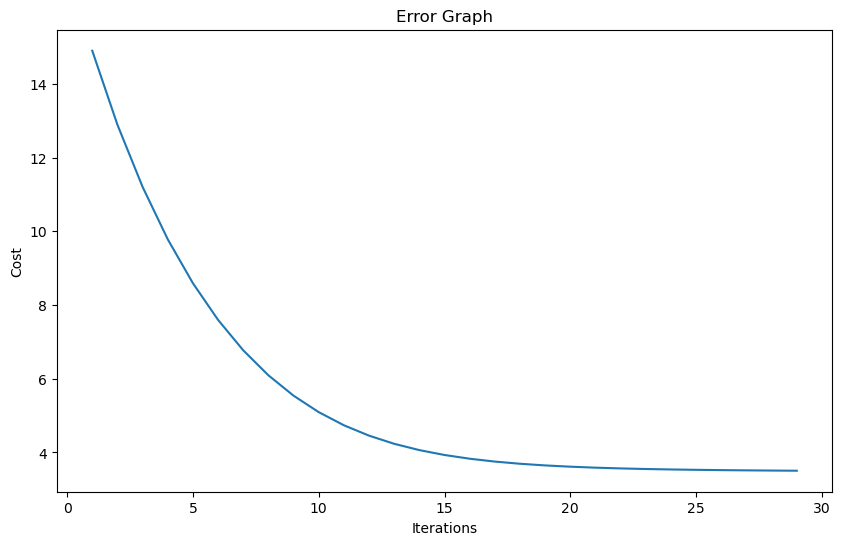

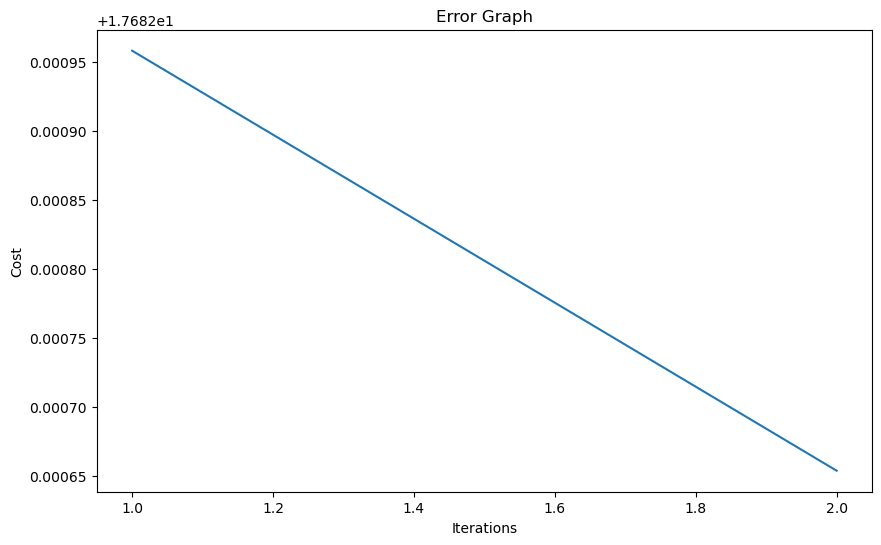

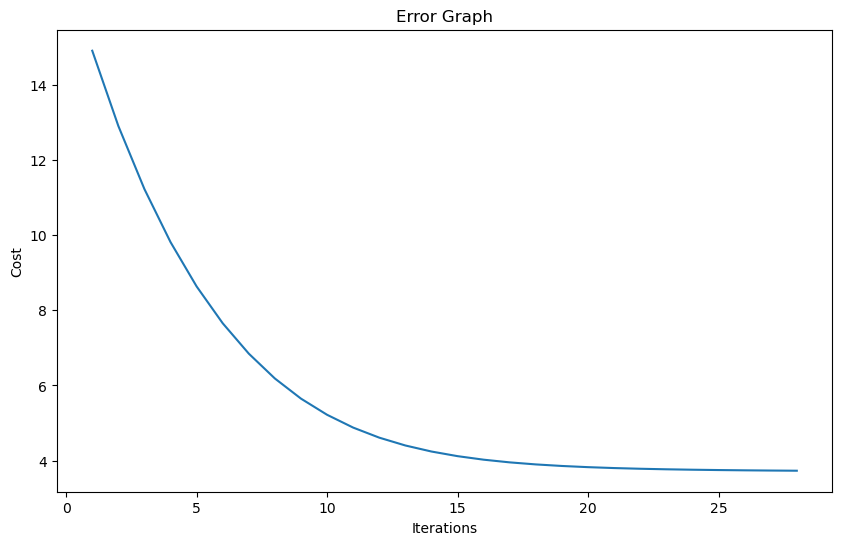

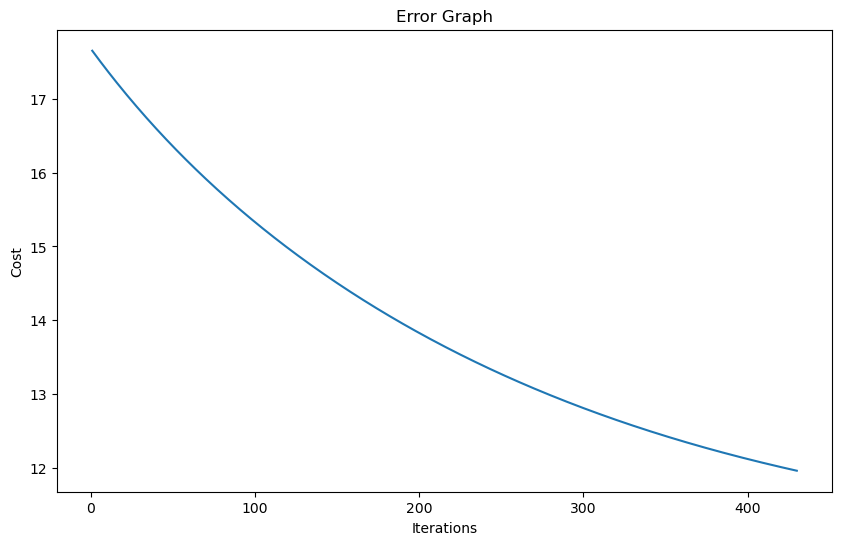

In [14]:
solver = LinearRegressionClass(data=X_train, target=y_train, learning_rate = 0.4e-3, epsilon = 0.5e-2, method = "gd", max_iterations = 50000)
solver.fit()
# Changed learning rate
solver = LinearRegressionClass(data=X_train, target=y_train, learning_rate = 0.4e-7, epsilon = 0.5e-2, method = "gd", max_iterations = 50000)
solver.fit()

solver = LinearRegressionClass(data=X_train, target=y_train, learning_rate = 0.4e-3, epsilon = 0.5e-2, method = "gd", max_iterations = 50000, reg_type = "L2", reg_lambda= 1)
solver.fit()
# reg_lambda change
solver = LinearRegressionClass(data=X_train, target=y_train, learning_rate = 0.4e-5, epsilon = 0.5e-2, method = "gd", max_iterations = 50000, reg_type = "L2", reg_lambda= 100)
solver.fit()

- We can observe the increase in steepness when we decrease the learning rate 
- and also increase in reg_lambda also increased the vhange in error

  0%|          | 28/49999 [00:00<00:01, 28169.95it/s]

Done
Gradient descent used
[22.81651814 -0.65636906  0.35572517 -0.29517019  0.82429271 -0.79582001
  3.41821314  0.08348477 -1.92931905  0.79335762 -0.2680021  -2.00448175
  1.12769012 -3.75828645]


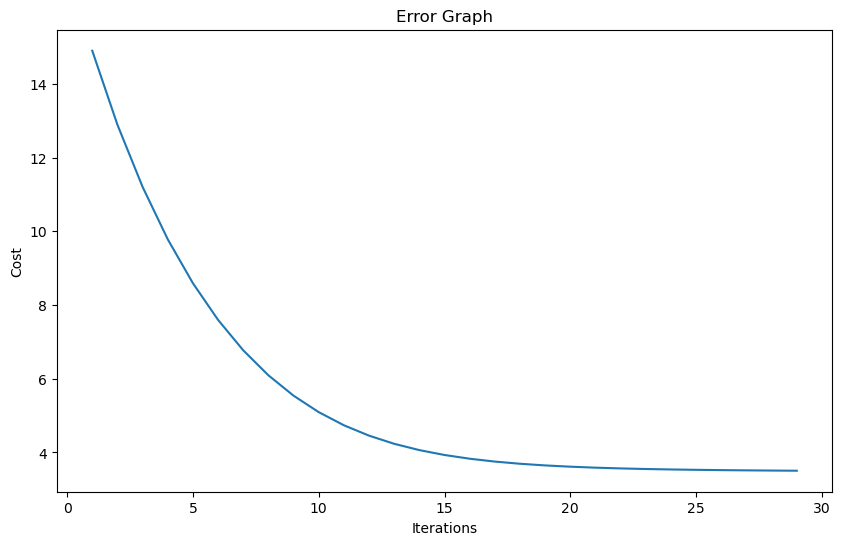

In [15]:
solver = LinearRegressionClass(data=X_train, target=y_train, learning_rate = 0.4e-3, epsilon = 0.5e-2, method = "gd", 
                               max_iterations = 50000, loss_function_type = "L2")
solver.fit()

## Analysis for yacht dataset

In [16]:
df1 = pd.read_csv("Dataset\yachtData.csv")
df1.head()

,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
0,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
1,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
2,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
3,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
4,-2.3,0.568,4.78,3.99,3.17,0.250,1.82


In [17]:
ppc = PreprocessingClass(data= df1, target_var= "0.11", test_split_ratio = 0.3)
ppc.fit()

X_train, X_test, y_train, y_test = ppc.X_train, ppc.X_test, ppc.y_train, ppc.y_test
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((214, 6), (93, 6), (214,), (93,))

In [18]:
solver = LinearRegressionClass(data= X_train, target= y_train)
solver.fit()

Closed Form used
[11.77457944  0.2403834   0.13881857  0.51531365 -0.59566118 -0.84890487
 12.97268282]


In [19]:
solver.evaluation_metrics(X = X_test, y = y_test, mode = 'train')
solver.evaluation_metrics(X = X_test, y = y_test, mode = 'test')

Training metrics
RMSE  8.84281110866059
SSE  16733.795976938538 

Test metrics
RMSE  8.983288194905308
SSE  7505.050411723432 



  0%|          | 18/49999 [00:00<00:02, 18009.89it/s]


Done
Gradient descent used
[11.65324788  0.27375695 -0.06218729 -0.075125   -0.04203333 -0.24435752
 12.83093651]


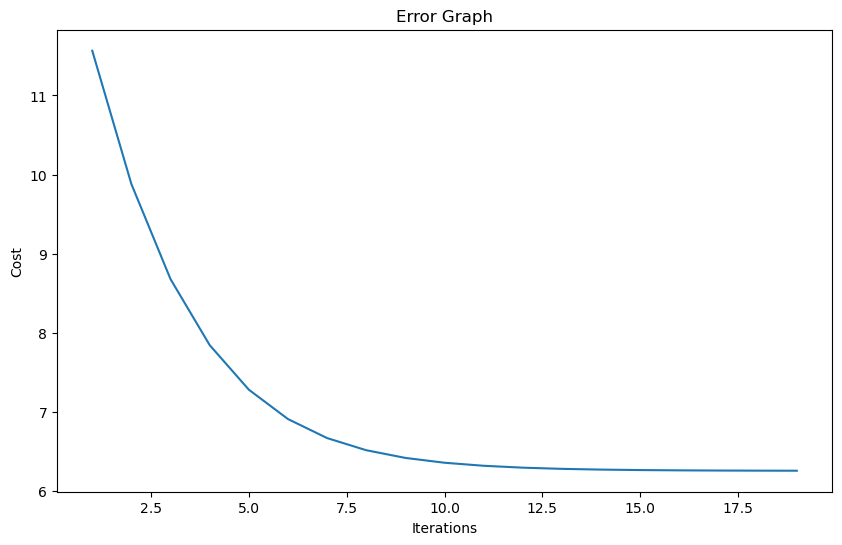

In [20]:
solver = LinearRegressionClass(data=X_train, target=y_train, learning_rate = 0.1e-2, epsilon = 0.1e-2, method = "gd", 
                               max_iterations = 50000, loss_function_type = "L2",reg_type="L1")
solver.fit()

In [21]:
solver.evaluation_metrics(X = X_test, y = y_test, mode = 'train')
solver.evaluation_metrics(X = X_test, y = y_test, mode = 'test')

Training metrics
RMSE  8.845500170399307
SSE  16743.97487861031 

Test metrics
RMSE  8.944531531434746
SSE  7440.431921465228 



- From the above results we can observe that training and testing both values are almost same when we used gradient descent.
- Based on the RMSE values, even when we use either normal method or gradient descent there is no much difference.

## Analysis for concrete dataset

In [22]:
df2 = pd.read_csv("Dataset\concreteData.csv")
df2.head()

,540,0,0.1,162,2.5,1040,676,28,79.99
0,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
1,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
3,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
4,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03


In [23]:
ppc = PreprocessingClass(data= df2, target_var= "79.99", test_split_ratio = 0.3)
ppc.fit()

X_train, X_test, y_train, y_test = ppc.X_train, ppc.X_test, ppc.y_train, ppc.y_test
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((720, 8), (309, 8), (720,), (309,))

In [24]:
solver = LinearRegressionClass(data= X_train, target= y_train)
solver.fit()

Closed Form used
[35.70425    13.01233187  9.42812661  5.37710957 -2.90445742  1.5433662
  1.01183192  1.77302852  6.72388457]


In [25]:
solver.evaluation_metrics(X = X_test, y = y_test, mode = 'train')
solver.evaluation_metrics(X = X_test, y = y_test, mode = 'test')

Training metrics
RMSE  10.07079851159755
SSE  73023.10751606071 

Test metrics
RMSE  11.031898655048499
SSE  37606.16147199561 



  0%|          | 123/49999 [00:00<00:01, 30748.56it/s]

Done
Gradient descent used
[35.70425    12.2718571   8.69660203  4.74460553 -3.53146893  1.46335932
  0.42757951  1.06227054  6.70278646]


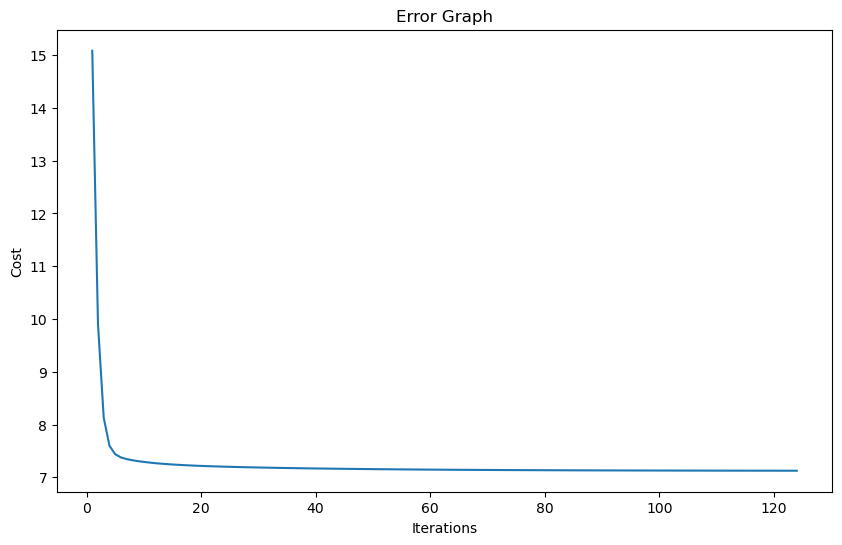

In [26]:
solver = LinearRegressionClass(data=X_train, target=y_train, learning_rate = 0.7e-3, epsilon = 0.1e-3, method = "gd", 
                               max_iterations = 50000, loss_function_type = "L2",reg_type="L1")
solver.fit()

In [27]:
solver.evaluation_metrics(X = X_test, y = y_test, mode = 'train')
solver.evaluation_metrics(X = X_test, y = y_test, mode = 'test')

Training metrics
RMSE  10.075106329919759
SSE  73085.59264261622 

Test metrics
RMSE  11.036685410947952
SSE  37638.803281811495 



- From the above results we can observe that training and testing both values are almost same when we used gradient descent.
- Based on the RMSE values, even when we use either normal method or gradient descent there is no much difference.

### SGD

 29%|██▉       | 14608/49999 [00:01<00:02, 12110.84it/s]


Done
Gradient descent used
[35.85145148 12.95604276  9.38889601  5.61529078 -3.00149673  1.43219178
  1.19911617  2.0327002   6.44926957]


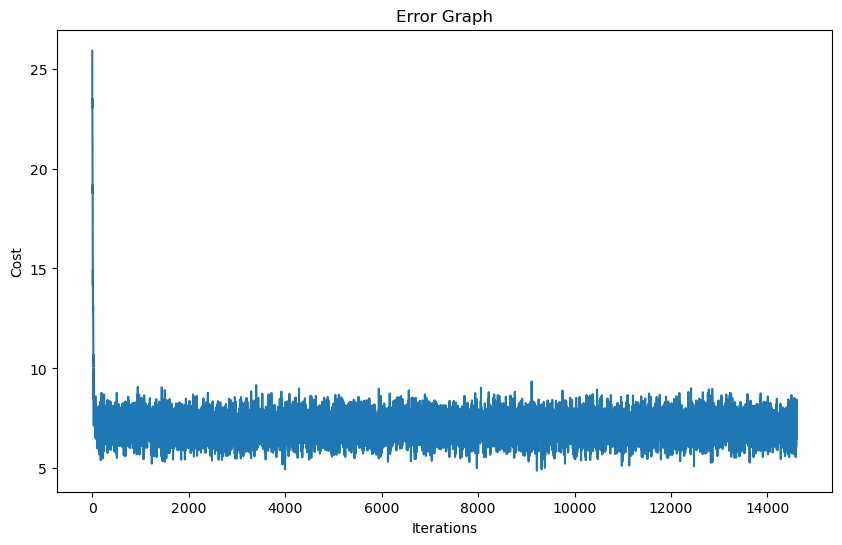

In [28]:
solver = LinearRegressionClass(data=X_train, target=y_train, learning_rate = 0.7e-3, epsilon = 0.1e-3, method = "sgd", 
                               max_iterations = 50000, loss_function_type = "L2",reg_type="L1")
solver.fit()